In [1]:
from typing import Sequence
from attrs import define, field
from tensorflow import cast, expand_dims
from tensorflow.math import reduce_mean, square
import tensorflow.keras as K
import numpy as np

2024-04-11 20:55:47.176773: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 20:55:47.662035: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
INPUT_SHAPE = (28, 28, 1)
BATCH_SIZE = 32
EPOCHS = 100

In [3]:
@define(frozen=True)
class Config:
    enc_conv_layers: int = field(kw_only=True)
    enc_conv_filters: Sequence[int] = field(kw_only=True)
    enc_conv_kernel_size: Sequence[Sequence[int]] = field(kw_only=True)
    enc_conv_strides: Sequence[int] = field(kw_only=True)
    latent_dim: int = field(kw_only=True)
    dec_conv_t_layers: int = field(kw_only=True)
    dec_conv_t_filters: Sequence[int] = field(kw_only=True)
    dec_conv_t_kernel_size: Sequence[Sequence[int]] = field(kw_only=True)
    dec_conv_t_strides: Sequence[int] = field(kw_only=True)
    origin_input_shape: Sequence[int] = field(kw_only=True)

In [4]:
class Encoder(K.layers.Layer):
    def __init__(self, config, name=None, **kwargs):
        super(Encoder, self).__init__()
        self.config = config
        
        self.leaky_relu = K.layers.LeakyReLU()
        self.conv_layers = [K.layers.Conv2D(
            filters=config.enc_conv_filters[i],
            kernel_size=config.enc_conv_kernel_size[i],
            strides=config.enc_conv_strides[i],
            padding='same',
            name=f"encoder_conv_{i}",
        ) for i in range(config.enc_conv_layers)]
        
        self.flatten = K.layers.Flatten()
        self.latent_layer = K.layers.Dense(config.latent_dim)
        
    def call(self, inputs):
        x = cast(expand_dims(inputs, -1), dtype="float32")
        for i in range(self.config.enc_conv_layers):
            x = self.conv_layers[i](x)
            x = self.leaky_relu(x)

        x = self.flatten(x)
        output = self.latent_layer(x)

        return output

In [5]:
class Decoder(K.layers.Layer):
    def __init__(self, config, name=None, **kwargs):
        super(Decoder ,self).__init__()
        self.config = config

        self.leaky_relu = K.layers.LeakyReLU()
        self.conv_t_layers = [K.layers.Conv2DTranspose(
            filters=config.dec_conv_t_filters[i],
            kernel_size=config.dec_conv_t_kernel_size[i],
            strides=config.dec_conv_t_strides[i],
            padding="same",
            name=f"decoder_conv_t_{i}"
        ) for i in range(self.config.dec_conv_t_layers)]

        shape_before_flatten = np.array(self.config.origin_input_shape[:-1]) // np.prod(self.config.enc_conv_strides)
        self.dense_layer = K.layers.Dense(units=np.prod(shape_before_flatten) * self.config.latent_dim, name="decoder_expanse")
        self.reshape = K.layers.Reshape(np.append(shape_before_flatten, self.config.latent_dim))
    
    def call(self, inputs):
        x = self.dense_layer(inputs)
        x = self.reshape(x)

        for i in range(self.config.dec_conv_t_layers):
            x = self.conv_t_layers[i](x)

            if i < self.config.dec_conv_t_layers - 1:
                x = self.leaky_relu(x)
        x = K.layers.Activation("sigmoid")(x)

        return x

In [6]:
class AutoEncoder(K.models.Model):
    def __init__(self, config: Config, name: str, *args, **kwargs):
        super(AutoEncoder, self).__init__(name, *args, **kwargs)
        self.encoder = Encoder(config, trainable=True)
        self.decoder = Decoder(config, trainable=True)
    
    def call(self, inputs):
        latent_representation = self.encoder(inputs)
        reconstructed_output = self.decoder(latent_representation)

        return reconstructed_output * 256

In [7]:
config = Config(
    enc_conv_layers = 4,
    enc_conv_filters = [32, 64, 64, 32], 
    enc_conv_kernel_size = [(3, 3), (3, 3), (3, 3), (3, 3)], 
    enc_conv_strides = [1, 2, 2, 1],
    latent_dim = 2,
    origin_input_shape = INPUT_SHAPE,
    dec_conv_t_layers = 4,
    dec_conv_t_filters = [64, 32, 32, 1],
    dec_conv_t_kernel_size = [(3, 3), (3, 3), (3, 3), (3, 3)],
    dec_conv_t_strides = [1, 2, 2, 1]
)

In [8]:
mnist_ds = K.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist_ds

In [9]:
#nor_x_train = x_train / 256
#nor_x_test = x_test / 256

In [10]:
def r_loss(y_true, y_pred):
    trans_y_true = cast(y_true, dtype="float32")
    trans_y_pred = cast(y_pred, dtype="float32")
    
    return reduce_mean(square(trans_y_true - trans_y_pred), axis=[1, 2])

In [11]:
model = AutoEncoder(config, name="MyAutoencoder")
model.compile(optimizer=K.optimizers.Adam(learning_rate=0.0001), loss=r_loss)

2024-04-11 20:55:48.416039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 20:55:48.433430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 20:55:48.433661: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [13]:
model.fit(x=x_train,
        y=x_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(x_test, x_test),
)

Epoch 1/100


2024-04-11 20:56:19.177304: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-11 20:56:19.721286: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-11 20:56:20.003563: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcd56ed3ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-11 20:56:20.003583: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-04-11 20:56:20.006130: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-11 20:56:20.076909: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

1875/1875 [==============================] - 9s 3ms/step - loss: 4305.3447 - val_loss: 3676.1355
Epoch 2/100
1875/1875 [==============================] - 5s 2ms/step - loss: 3611.7720 - val_loss: 3562.5825
Epoch 3/100
1875/1875 [==============================] - 5s 2ms/step - loss: 3525.4531 - val_loss: 3483.6277
Epoch 4/100
1875/1875 [==============================] - 5s 2ms/step - loss: 3469.4202 - val_loss: 3435.9688
Epoch 5/100
1875/1875 [==============================] - 5s 2ms/step - loss: 3427.7693 - val_loss: 3409.6245
Epoch 6/100
1875/1875 [==============================] - 5s 2ms/step - loss: 3393.9316 - val_loss: 3390.1704
Epoch 7/100
1875/1875 [==============================] - 5s 2ms/step - loss: 3367.0239 - val_loss: 3349.3911
Epoch 8/100
1875/1875 [==============================] - 5s 2ms/step - loss: 3340.1746 - val_loss: 3313.8787
Epoch 9/100
1875/1875 [==============================] - 5s 2ms/step - loss: 3319.2656 - val_loss: 3297.9175
Epoch 10/100
1875/1875 [=======

In [ ]:
latent_output = model.encoder(x_test)

In [ ]:
import matplotlib.pyplot as plt

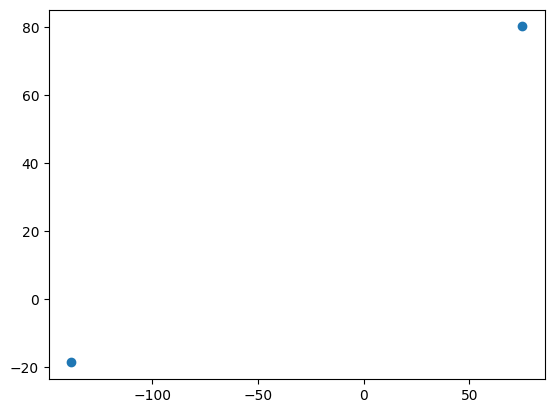

In [ ]:
#plt.scatter(latent_output[0:][0], latent_output[0:][1])

In [ ]:
model.summary()

Model: "auto_encoder_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         multiple                  80834     
                                                                 
 decoder_3 (Decoder)         multiple                  21145     
                                                                 
Total params: 101979 (398.36 KB)
Trainable params: 101979 (398.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
